In [22]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
events_data_train = pd.read_csv('https://stepik.org/media/attachments/course/4852/event_data_train.zip')
submissions_data_train = pd.read_csv('https://stepik.org/media/attachments/course/4852/submissions_data_train.zip')

In [3]:
events_data_train.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


In [5]:
submissions_data_train.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [29]:
events_data_train['date'] = pd.to_datetime(events_data_train['timestamp'], unit='s')
events_data_train.head()

,step_id,timestamp,action,user_id,date
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48
1,32815,1434340848,passed,17632,2015-06-15 04:00:48
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35


In [30]:
events_data_train['day'] = events_data_train.date.dt.date
events_data_train.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [24]:
events_data_train.pivot_table(index='user_id',
                              columns='action',
                              values='step_id',
                              aggfunc='count',
                              fill_value=0
                             )\
    .reset_index()\
    .sort_values(by='started_attempt', ascending=False)\
    .head(10)

action,user_id,discovered,passed,started_attempt,viewed
781,1046,128,124,721,8122
2611,3572,194,193,550,6968
6062,8394,131,94,337,1070
4825,6662,198,197,285,1054
1204,1649,194,194,281,807
5565,7702,187,115,276,1328
3938,5454,195,195,265,1167
3700,5096,184,178,232,1608
15512,21602,191,191,227,408
4007,5552,198,198,224,1141


In [61]:
users_scores = submissions_data_train.pivot_table(index='user_id',
                              columns='submission_status',
                              values='step_id',
                              aggfunc='count',
                              fill_value=0
                             ).reset_index()

In [26]:
user_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


In [43]:
gap_data = events_data_train[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day'])\
    .groupby('user_id')['timestamp'].apply(list)\
    .apply(np.diff).values

In [44]:
gap_data = pd.Series(np.concatenate(gap_data, axis=0)) / (24 * 60 * 60)

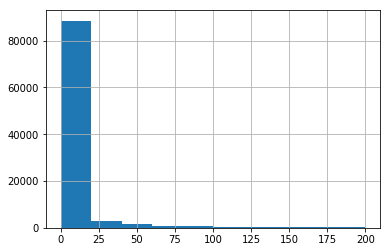

In [46]:
gap_data[gap_data < 200].hist()

In [47]:
gap_data.quantile(0.95)

59.760440972222156

In [72]:
users_data = events_data_train.groupby('user_id', as_index=False)\
    .agg({'timestamp': 'max'}).rename(columns={'timestamp': 'last_timestamp'})

In [56]:
now = 1526772811
drop_out_threshold = (30 * 24 * 60 * 60)

In [73]:
users_data['is_gone_user'] = (now - users_data.last_timestamp) > drop_out_threshold

In [74]:
users_data.head()

,user_id,last_timestamp,is_gone_user
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True


In [75]:
users_data = users_data.merge(users_scores, on='user_id', how='outer').fillna(0)

In [77]:
users_events_data = events_data_train.pivot_table(index='user_id',
                              columns='action',
                              values='step_id',
                              aggfunc='count',
                              fill_value=0
                             ).reset_index()

In [78]:
users_events_data.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


In [79]:
users_data = users_data.merge(users_events_data, how='outer')

In [80]:
users_data.head(20)

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed
0,1,1472827464,True,0.0,0.0,1,0,0,1
1,2,1519226966,True,2.0,0.0,9,9,2,10
2,3,1444581588,True,29.0,23.0,91,87,30,192
3,5,1499859939,True,2.0,2.0,11,11,4,12
4,7,1521634660,True,0.0,0.0,1,1,0,1
5,8,1481466913,True,9.0,21.0,109,84,37,156
6,9,1484999497,True,0.0,0.0,3,3,0,4
7,11,1526140625,False,0.0,0.0,1,0,1,1
8,14,1436368676,True,0.0,1.0,4,3,1,9
9,16,1513162585,True,77.0,106.0,196,196,108,651


In [83]:
users_days = events_data_train.groupby('user_id').day.nunique().to_frame().reset_index()

In [84]:
users_days.head()

,user_id,day
0,1,1
1,2,2
2,3,7
3,5,2
4,7,1


In [85]:
users_data = users_data.merge(users_days, how='outer')

In [90]:
users_data['passed_course'] = users_data.passed > 170

In [92]:
users_data.groupby('passed_course').count()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
passed_course,,,,,,,,,,
False,17809,17809,17809,17809,17809,17809,17809,17809,17809,17809
True,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425
